<a href="https://colab.research.google.com/github/shadowscythe03/es335-24-fall-assignment-2/blob/master/task_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [50]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import os
import requests
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

dog.jpg exists
torch.Size([3, 1365, 2048])
torch.Size([1365, 2048])


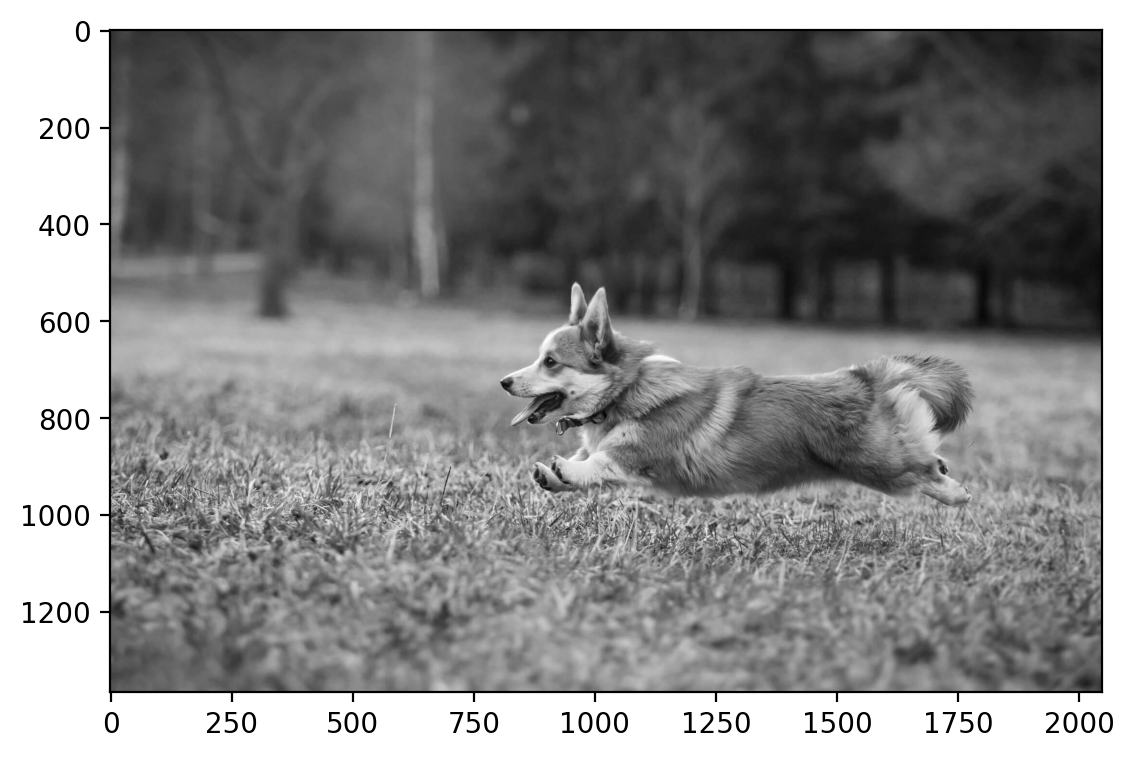

In [20]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    url = 'https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg'
    response = requests.get(url)
    if response.status_code == 200:
        with open('dog.jpg', 'wb') as file:
            file.write(response.content)
        print('dog.jpg downloaded successfully')
    else:
        print('Failed to download dog.jpg')

img = torchvision.io.read_image("dog.jpg")
print(img.shape)
img = img.clone().detach().float()
# print(img.shape)
img = img.mean(dim=0, keepdim=False)
print(img.shape)

plt.imshow(img, cmap='gray')

torch.Size([300, 300])


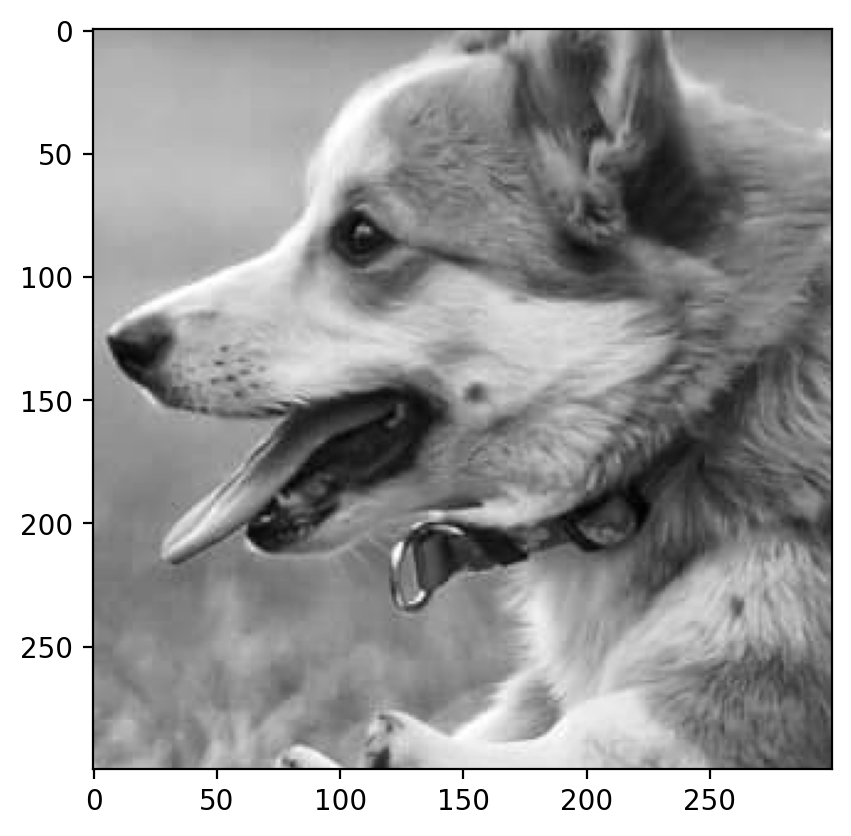

In [22]:
crop = torchvision.transforms.functional.crop(img, 600, 800, 300, 300)
print(crop.shape)
plt.imshow(crop, cmap='gray')

tensor(26885)


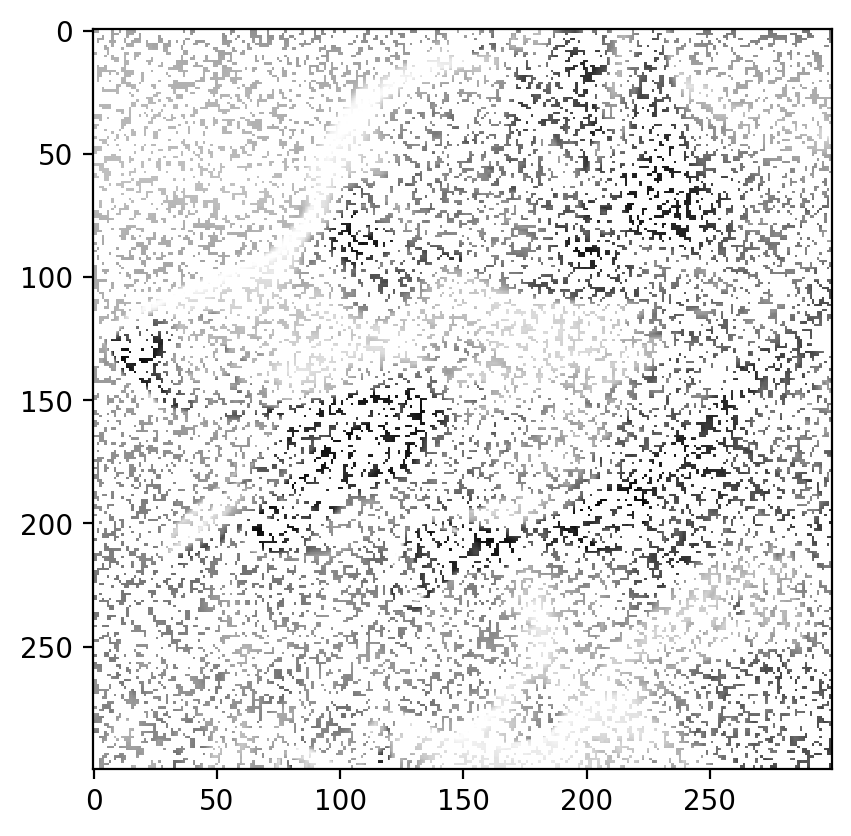

In [48]:
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
def mask_image(img, prop):
    img_copy = img.clone()
    mask = torch.rand(img.shape) < prop
    img_copy[mask] = float('nan')
    return img_copy, mask

masked_image, mask = mask_image(crop, 0.3)
print(mask.sum())
plt.imshow(masked_image, cmap='gray')

In [51]:
# def factorize(A, k, device=torch.device("cpu")):
#     """Factorize the matrix A into W and H
#     A: input matrix of size (n_users, n_movies)
#     k: number of latent features
    
#     Returns W and H
#     W: matrix of size (n_users, k)
#     H: matrix of size (k, n_movies)
#     """
#     A = A.to(device)
#     # Randomly initialize W and H
#     W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
#     H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    
#     # Optimizer
#     optimizer = optim.Adam([W, H], lr=0.01)
    
#     # Train the model
#     for i in range(1000):
#         # Compute the loss
#         loss = torch.norm(torch.mm(W, H) - A)
        
#         # Zero the gradients
#         optimizer.zero_grad()
        
#         # Backpropagate
#         loss.backward()
        
#         # Update the parameters
#         optimizer.step()
        
#     return W, H, loss

def factorize(A, k, device=torch.device("cpu")):
    """Factorize the matrix D into A and B"""
    A = A.to(device)
    # Randomly initialize A and B
    W = torch.randn(A.shape[0], k, requires_grad=True, device=device)
    H = torch.randn(k, A.shape[1], requires_grad=True, device=device)
    # Optimizer
    optimizer = optim.Adam([W, H], lr=0.01)
    mask = ~torch.isnan(A)
    # Train the model
    for i in range(1000):
        # Compute the loss
        diff_matrix = torch.mm(W, H) - A
        diff_vector = diff_matrix[mask]
        loss = torch.norm(diff_vector)
        
        # Zero the gradients
        optimizer.zero_grad()
        
        # Backpropagate
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
    return W, H, loss

W, H, loss = factorize(masked_image, 50, device=device)

In [52]:
loss

tensor(1361.9554, grad_fn=<LinalgVectorNormBackward0>)

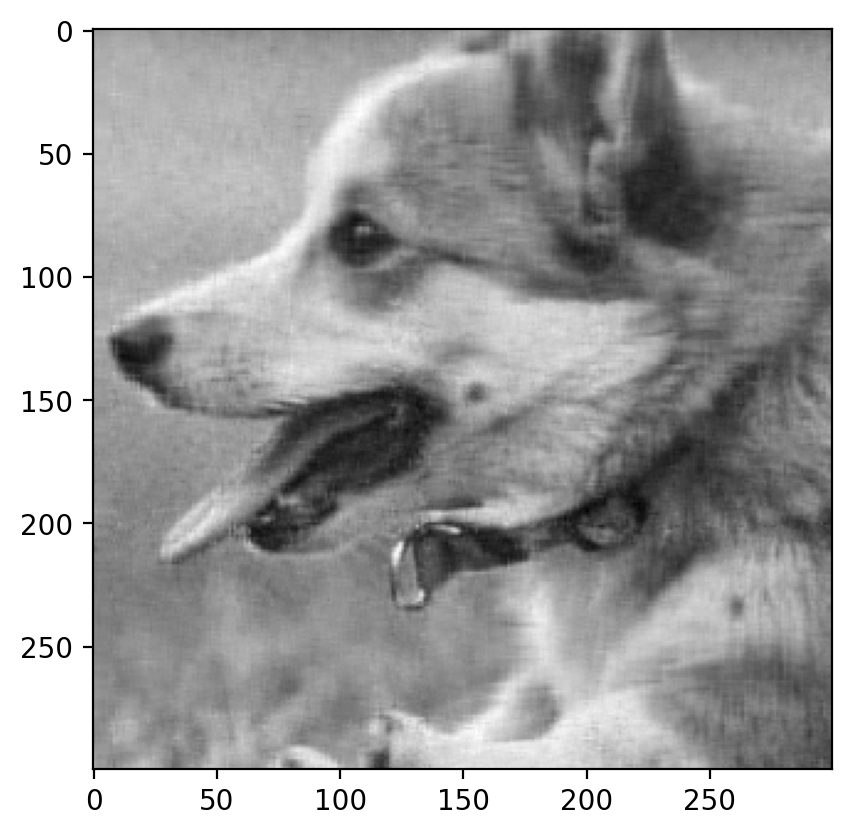

In [53]:
plt.imshow(torch.mm(W, H).cpu().detach().numpy(), cmap='gray')

In [ ]:
%pip install ipywidgets

In [56]:
from ipywidgets import interact, widgets
def plot_image_completion(prop=0.1, factors=50):
    masked_img, mask = mask_image(crop, prop)
    W, H, loss = factorize(masked_img, factors, device=device)
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    reconstructed_img = torch.mm(W, H).cpu().detach().numpy()
    ax[0].imshow(masked_img, cmap='gray')
    ax[0].set_title("Masked image")
    ax[1].imshow(reconstructed_img, cmap='gray')
    ax[1].set_title("Reconstructed image")

interact(plot_image_completion, prop=widgets.FloatSlider(min=0.01, max=0.9, step=0.01, value=0.3), factors=widgets.IntSlider(min=1, max=150, step=1, value=50))